![Task description](tresc.png)

# Model Isinga
`G = (V, E)` - graf o `N` wierzchołkach. `Φ = {(s_1, ..., s_N) : ∀ i s_i ∈ {-1, +1}} = {-1, +1}^N` - przestrzeń stanów. 

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import csv
import os
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

In [2]:
class Graph:
    def get_ajacency_matrix(self):
        raise NotImplementedError("Subclasses must implement this method")

class LatticeGraph(Graph):
    # Graf regularnej dwuwymiarowej kraty L×L.
    # Każdy wierzchołek ma do 4 sąsiadów (góra, dół, lewo, prawo).
    # Symuluje klasyczny fizyczny model Isinga na siatce.
    def __init__(self, L):
        self.L = L

    def get_ajacency_matrix(self):
        L = self.L
        N = L * L
        A = np.zeros((N, N), dtype=int)
        for i in range(L):
            for j in range(L):
                idx = i * L + j
                if i > 0:
                    A[idx, idx - L] = 1
                if i < L - 1:
                    A[idx, idx + L] = 1
                if j > 0:
                    A[idx, idx - 1] = 1
                if j < L - 1:
                    A[idx, idx + 1] = 1
        return A

class CompleteGraph(Graph):
    # Graf pełny o N wierzchołkach – każdy wierzchołek połączony z każdym innym.
    # Modeluje sytuację, w której oddziaływują wszystkie spiny ze sobą.
    def __init__(self, N):
        self.N = N

    def get_ajacency_matrix(self):
        N = self.N
        A = np.ones((N, N), dtype=int) - np.eye(N, dtype=int)
        return A

class ErdosRenyiGraph(Graph):
    # Losowy graf G(n, p), gdzie każda para wierzchołków jest połączona z prawdopodobieństwem p.
    # Modeluje nieuporządkowane interakcje – sieci z przypadkowymi połączeniami.    
    def __init__(self, N, p):
        self.N = N
        self.p = p

    def get_ajacency_matrix(self):
        G = nx.erdos_renyi_graph(self.N, self.p)
        A = nx.to_numpy_array(G, dtype=int)
        return A

class WattsStrogatzGraph(Graph):
    # Graf małego świata – zaczyna się od regularnego pierścienia (każdy z k sąsiadami),
    # a następnie część krawędzi jest losowo przetasowana z prawdopodobieństwem p.
    # Reprezentuje systemy z lokalną strukturą i nielicznymi dalekimi połączeniami.
    def __init__(self, N, k, p):
        self.N = N
        self.k = k
        self.p = p

    def get_ajacency_matrix(self):
        G = nx.watts_strogatz_graph(self.N, self.k, self.p)
        A = nx.to_numpy_array(G, dtype=int)
        return A

class BarabasiAlbertGraph(Graph):
    # Graf ze wzrostem preferencyjnym – nowe wierzchołki dołączają do istniejących
    # z prawdopodobieństwem proporcjonalnym do ich stopnia.
    # Tworzy sieci ze strukturą skali – kilka wysoko połączonych węzłów (huby).
    def __init__(self, N, m):
        self.N = N
        self.m = m

    def get_ajacency_matrix(self):
        G = nx.barabasi_albert_graph(self.N, self.m)
        A = nx.to_numpy_array(G, dtype=int)
        return A


In [3]:
g = LatticeGraph(2)
g.get_ajacency_matrix()

array([[0, 1, 1, 0],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [0, 1, 1, 0]])

In [4]:
class IsingModel:
    def __init__(self, adjacency_matrix, name, T, steps=100_000, burn_in=20_000, sample_every=100):
        """
        Model Isinga z próbnikem Gibbsa dla dowolnego grafu.
        
        Parametry:
        - adjacency_matrix: macierz sąsiedztwa grafu (numpy array)
        - name: nazwa grafu (do wyświetlania w wynikach)
        - T: temperatura (float)
        - steps: całkowita liczba kroków próbnika Gibbsa
        - burn_in: liczba kroków, które pomijamy przed pomiarem magnetyzacji (dla osiągnięcia stanu stacjonarnego)
        - sample_every: co ile kroków po burn-in zbieramy pomiary magnetyzacji
        """
        self.adjacency_matrix = adjacency_matrix
        self.name = name
        self.N = adjacency_matrix.shape[0]
        self.steps = steps
        self.burn_in = burn_in
        self.sample_every = sample_every
        self.T = T
        self.beta = 1.0 / T  # β = 1 / T (odwrotność temperatury)
        self.J, self.h = self._generate_ising_parameters()

    def _generate_ising_parameters(self):
        """
        Generuje losowe interakcje J_ij (między sąsiadującymi spinami)
        oraz pola zewnętrzne h_i dla każdego spinu.
        """
        J = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(i + 1, self.N):
                if self.adjacency_matrix[i, j]:
                    # Losowa siła oddziaływania J_ij z przedziału [0.5, 1.5]
                    p = np.random.uniform(0.5, 1.5)
                    J[i, j] = p
                    J[j, i] = p
        # Losowe pole zewnętrzne h_i z przedziału [-0.5, 0.5]
        h = np.random.uniform(-0.5, 0.5, size=self.N)
        return J, h

    def run_gibbs_sampler(self):
        """
        Uruchamia próbnik Gibbsa:
        - inicjalizuje losowo spiny,
        - w każdym kroku wybiera losowy spin i aktualizuje go warunkowo,
        - po okresie "burn-in" zbiera próbki magnetyzacji.
        
        Zwraca:
        - średnią magnetyzację |M| po burn-in,
        - odchylenie standardowe.
        """
        spins = np.random.choice([-1, 1], size=self.N)
        magnetizations = []

        for step in range(self.steps):
            selected_spin = np.random.randint(self.N)
            # Oblicz pole działające na wybrany spin
            H = np.sum(self.J[selected_spin] * spins) + self.h[selected_spin]
            # Prawdopodobieństwo przyjęcia wartości +1
            p = 1 / (1 + np.exp(-2 * self.beta * H))
            spins[selected_spin] = 1 if np.random.rand() < p else -1

            # Po burn-in zbieramy magnetyzację co sample_every kroków
            if step >= self.burn_in and (step - self.burn_in) % self.sample_every == 0:
                m = np.abs(np.sum(spins)) / self.N
                magnetizations.append(m)

        return np.mean(magnetizations), np.std(magnetizations)

    def simulate(self):
        """
        Przeprowadza pełną symulację dla jednej temperatury.
        Zwraca temperaturę, średnią magnetyzację i odchylenie standardowe.
        """
        m_mean, m_std = self.run_gibbs_sampler()
        print(f"{self.name} | T = {self.T:.2f}, Magnetization = {m_mean:.4f}")
        return self.T, m_mean, m_std


## Przejścia fazowe

Lattice | T = 0.10, Magnetization = 1.0000
Lattice | T = 0.10, Magnetization = 1.0000
Lattice | T = 0.10, Magnetization = 1.0000
Lattice | T = 0.10, Magnetization = 1.0000
Lattice | T = 0.13, Magnetization = 1.0000
Lattice | T = 0.13, Magnetization = 1.0000
Lattice | T = 0.13, Magnetization = 1.0000
Lattice | T = 0.13, Magnetization = 1.0000
Lattice | T = 0.17, Magnetization = 1.0000
Lattice | T = 0.17, Magnetization = 1.0000
Lattice | T = 0.17, Magnetization = 1.0000
Lattice | T = 0.17, Magnetization = 1.0000
Lattice | T = 0.20, Magnetization = 1.0000
Lattice | T = 0.20, Magnetization = 1.0000
Lattice | T = 0.20, Magnetization = 1.0000
Lattice | T = 0.20, Magnetization = 1.0000
Lattice | T = 0.23, Magnetization = 1.0000
Lattice | T = 0.23, Magnetization = 1.0000
Lattice | T = 0.23, Magnetization = 1.0000
Lattice | T = 0.23, Magnetization = 1.0000
Lattice | T = 0.27, Magnetization = 1.0000
Lattice | T = 0.27, Magnetization = 1.0000
Lattice | T = 0.27, Magnetization = 0.9994
Lattice | T

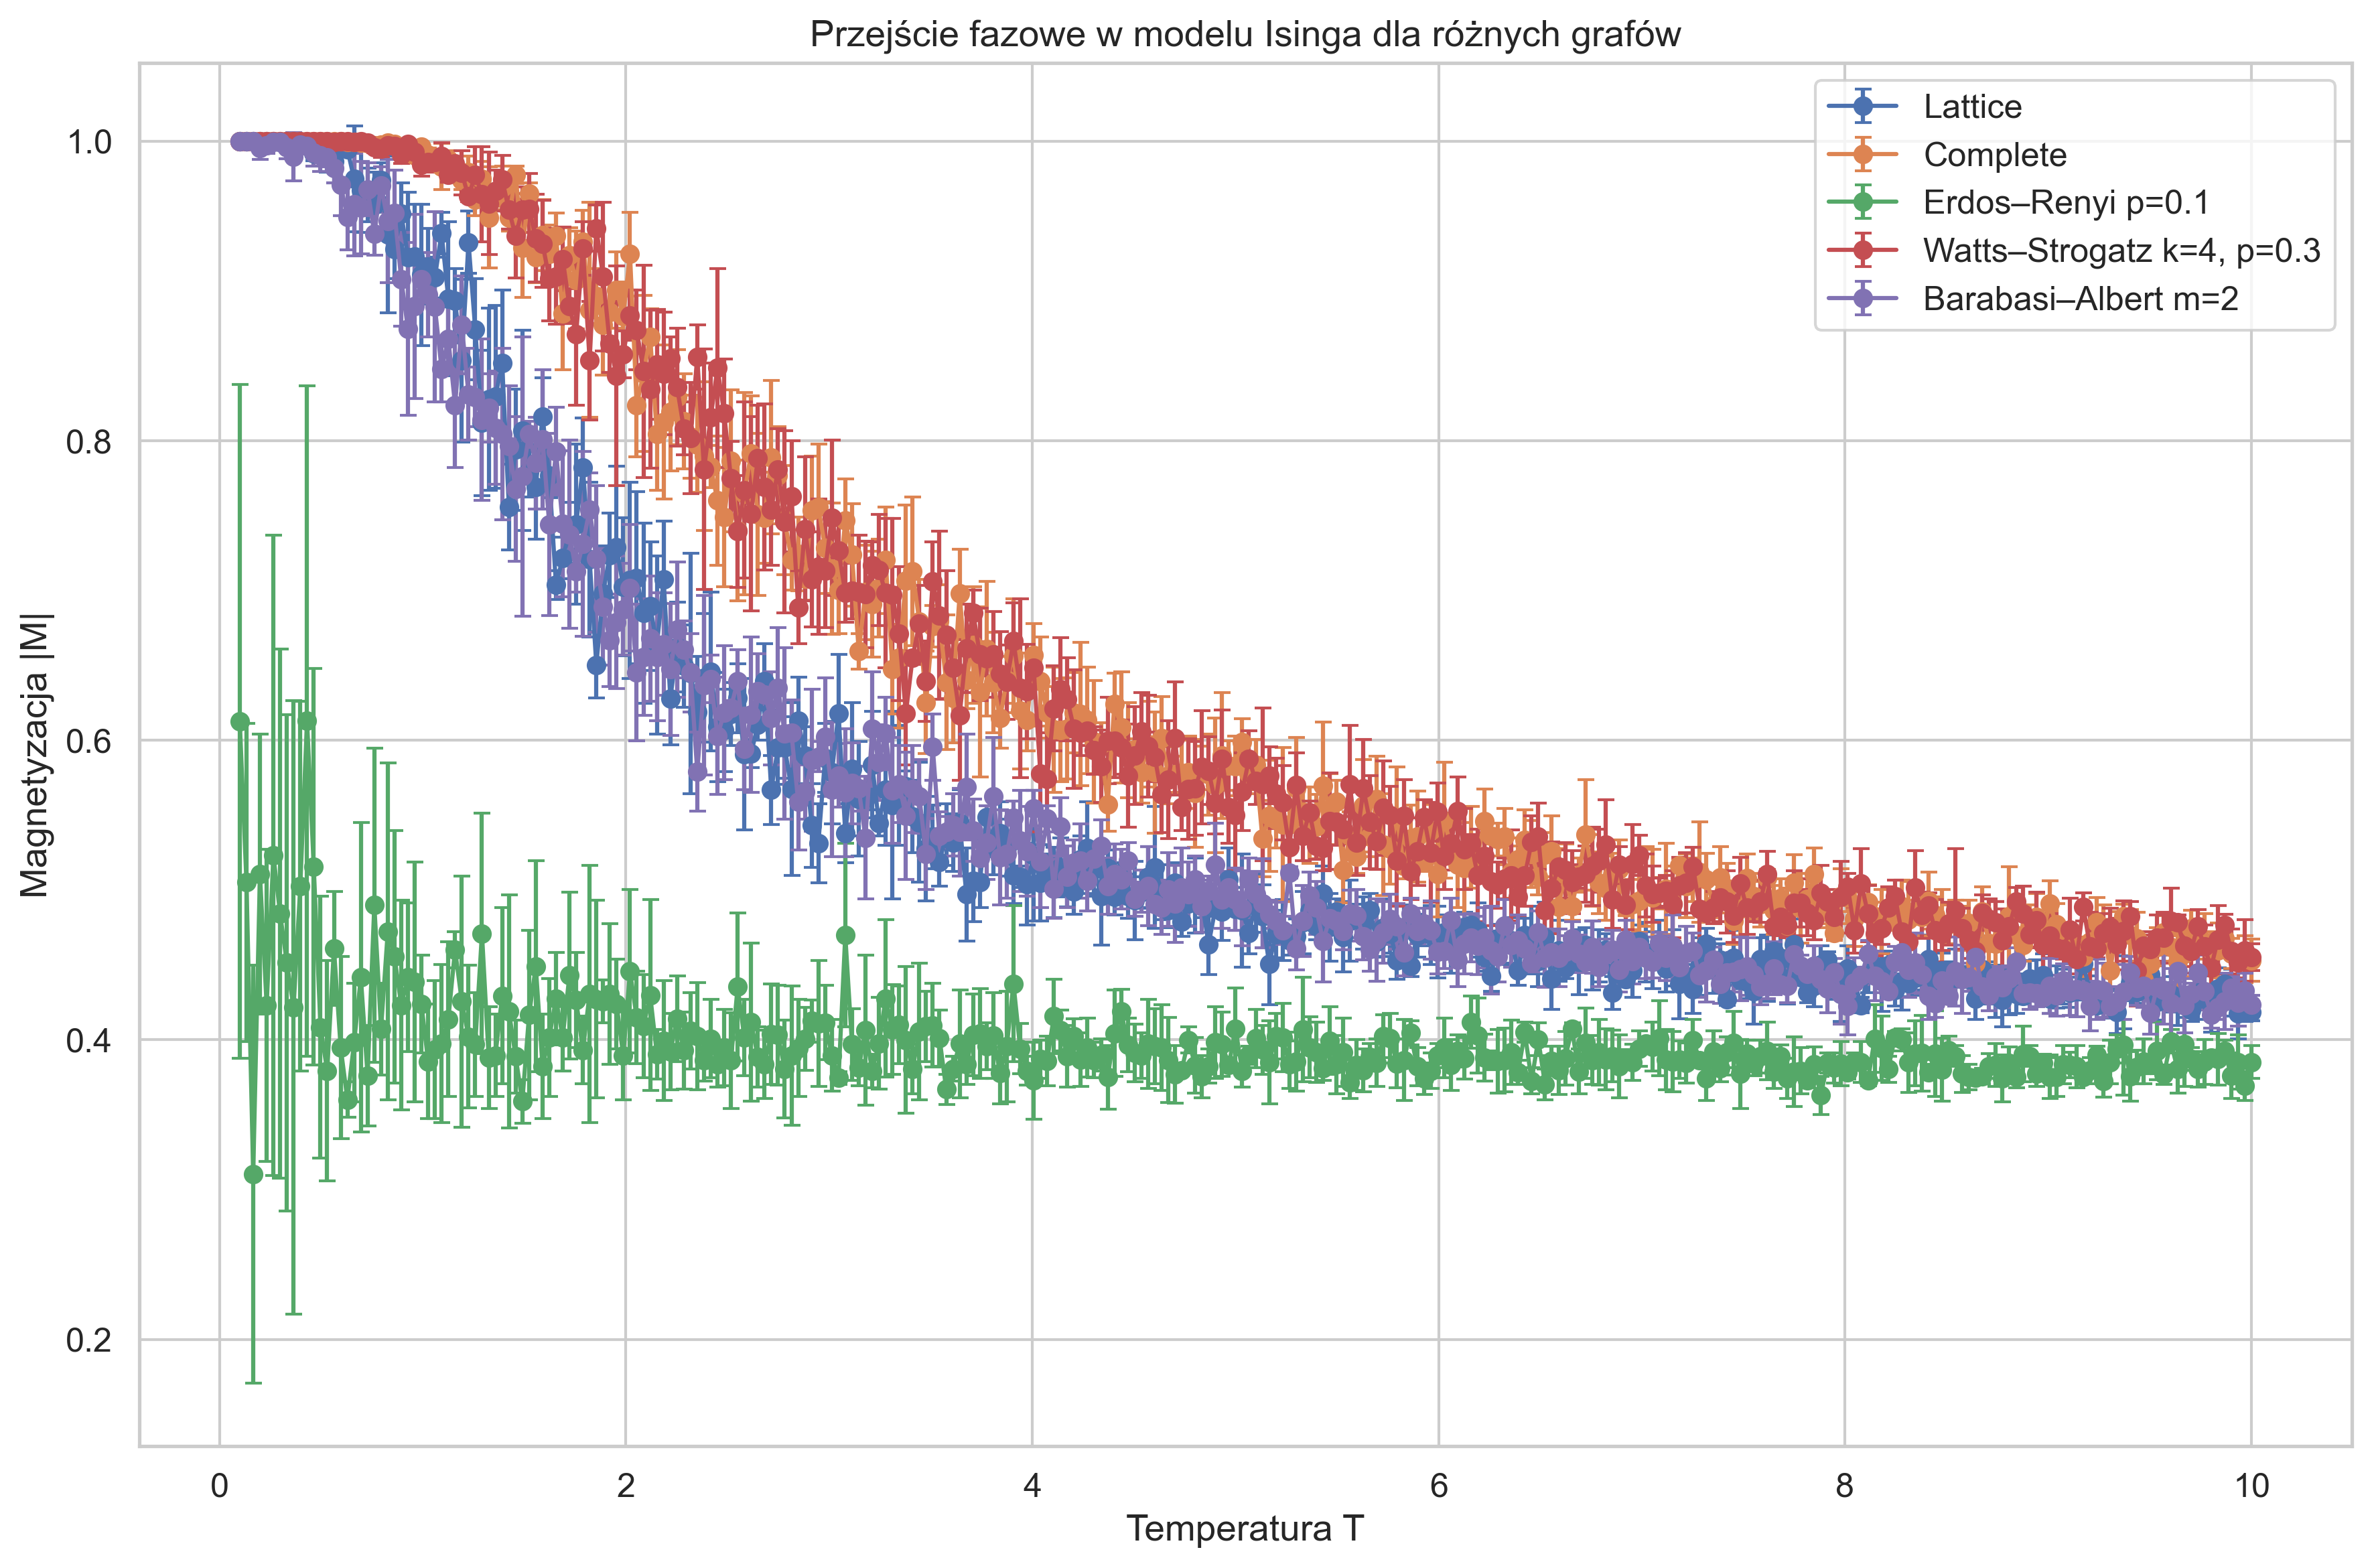

In [65]:
L = 2
N = L * L
T_values = np.linspace(0.1, 10.0, 300)
repeats = 4

plt.figure(figsize=(12, 8), dpi=300)

graph_configs = [
    (lambda: LatticeGraph(L).get_ajacency_matrix(), "Lattice"),
    (lambda: CompleteGraph(N).get_ajacency_matrix(), "Complete"),
    (lambda: ErdosRenyiGraph(N, p=0.1).get_ajacency_matrix(), "Erdos–Renyi p=0.1"),
    (lambda: WattsStrogatzGraph(N, k=4, p=0.3).get_ajacency_matrix(), "Watts–Strogatz k=4, p=0.3"),
    (lambda: BarabasiAlbertGraph(N, m=2).get_ajacency_matrix(), "Barabasi–Albert m=2")
]

for graph_gen, name in graph_configs:
    means, stds = [], []

    for T in T_values:
        m_vals = []
        for _ in range(repeats):
            A = graph_gen()
            model = IsingModel(A, name, T)
            _, m, _ = model.simulate()
            m_vals.append(m)
        means.append(np.mean(m_vals))
        stds.append(np.std(m_vals))

    os.makedirs("results_2x2", exist_ok=True)
    filename = f"results_2x2/{name}.csv"

    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["T", "mean_magnetization", "std_magnetization"])
        for t, mean, std in zip(T_values, means, stds):
            writer.writerow([t, mean, std])

    plt.errorbar(T_values, means, yerr=stds, fmt='o-', label=name, capsize=3)

plt.title("Przejście fazowe w modelu Isinga dla różnych grafów")
plt.xlabel("Temperatura T")
plt.ylabel("Magnetyzacja |M|")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/zl/cns9wcts6cd33lrhp33f3rsc0000gn/T/ipykernel_26508/621715004.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["graph"] = name
/var/folders/zl/cns9wcts6cd33lrhp33f3rsc0000gn/T/ipykernel_26508/621715004.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["graph"] = name
/var/folders/zl/cns9wcts6cd33lrhp33f3rsc0000gn/T/ipykernel_26508/621715004.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

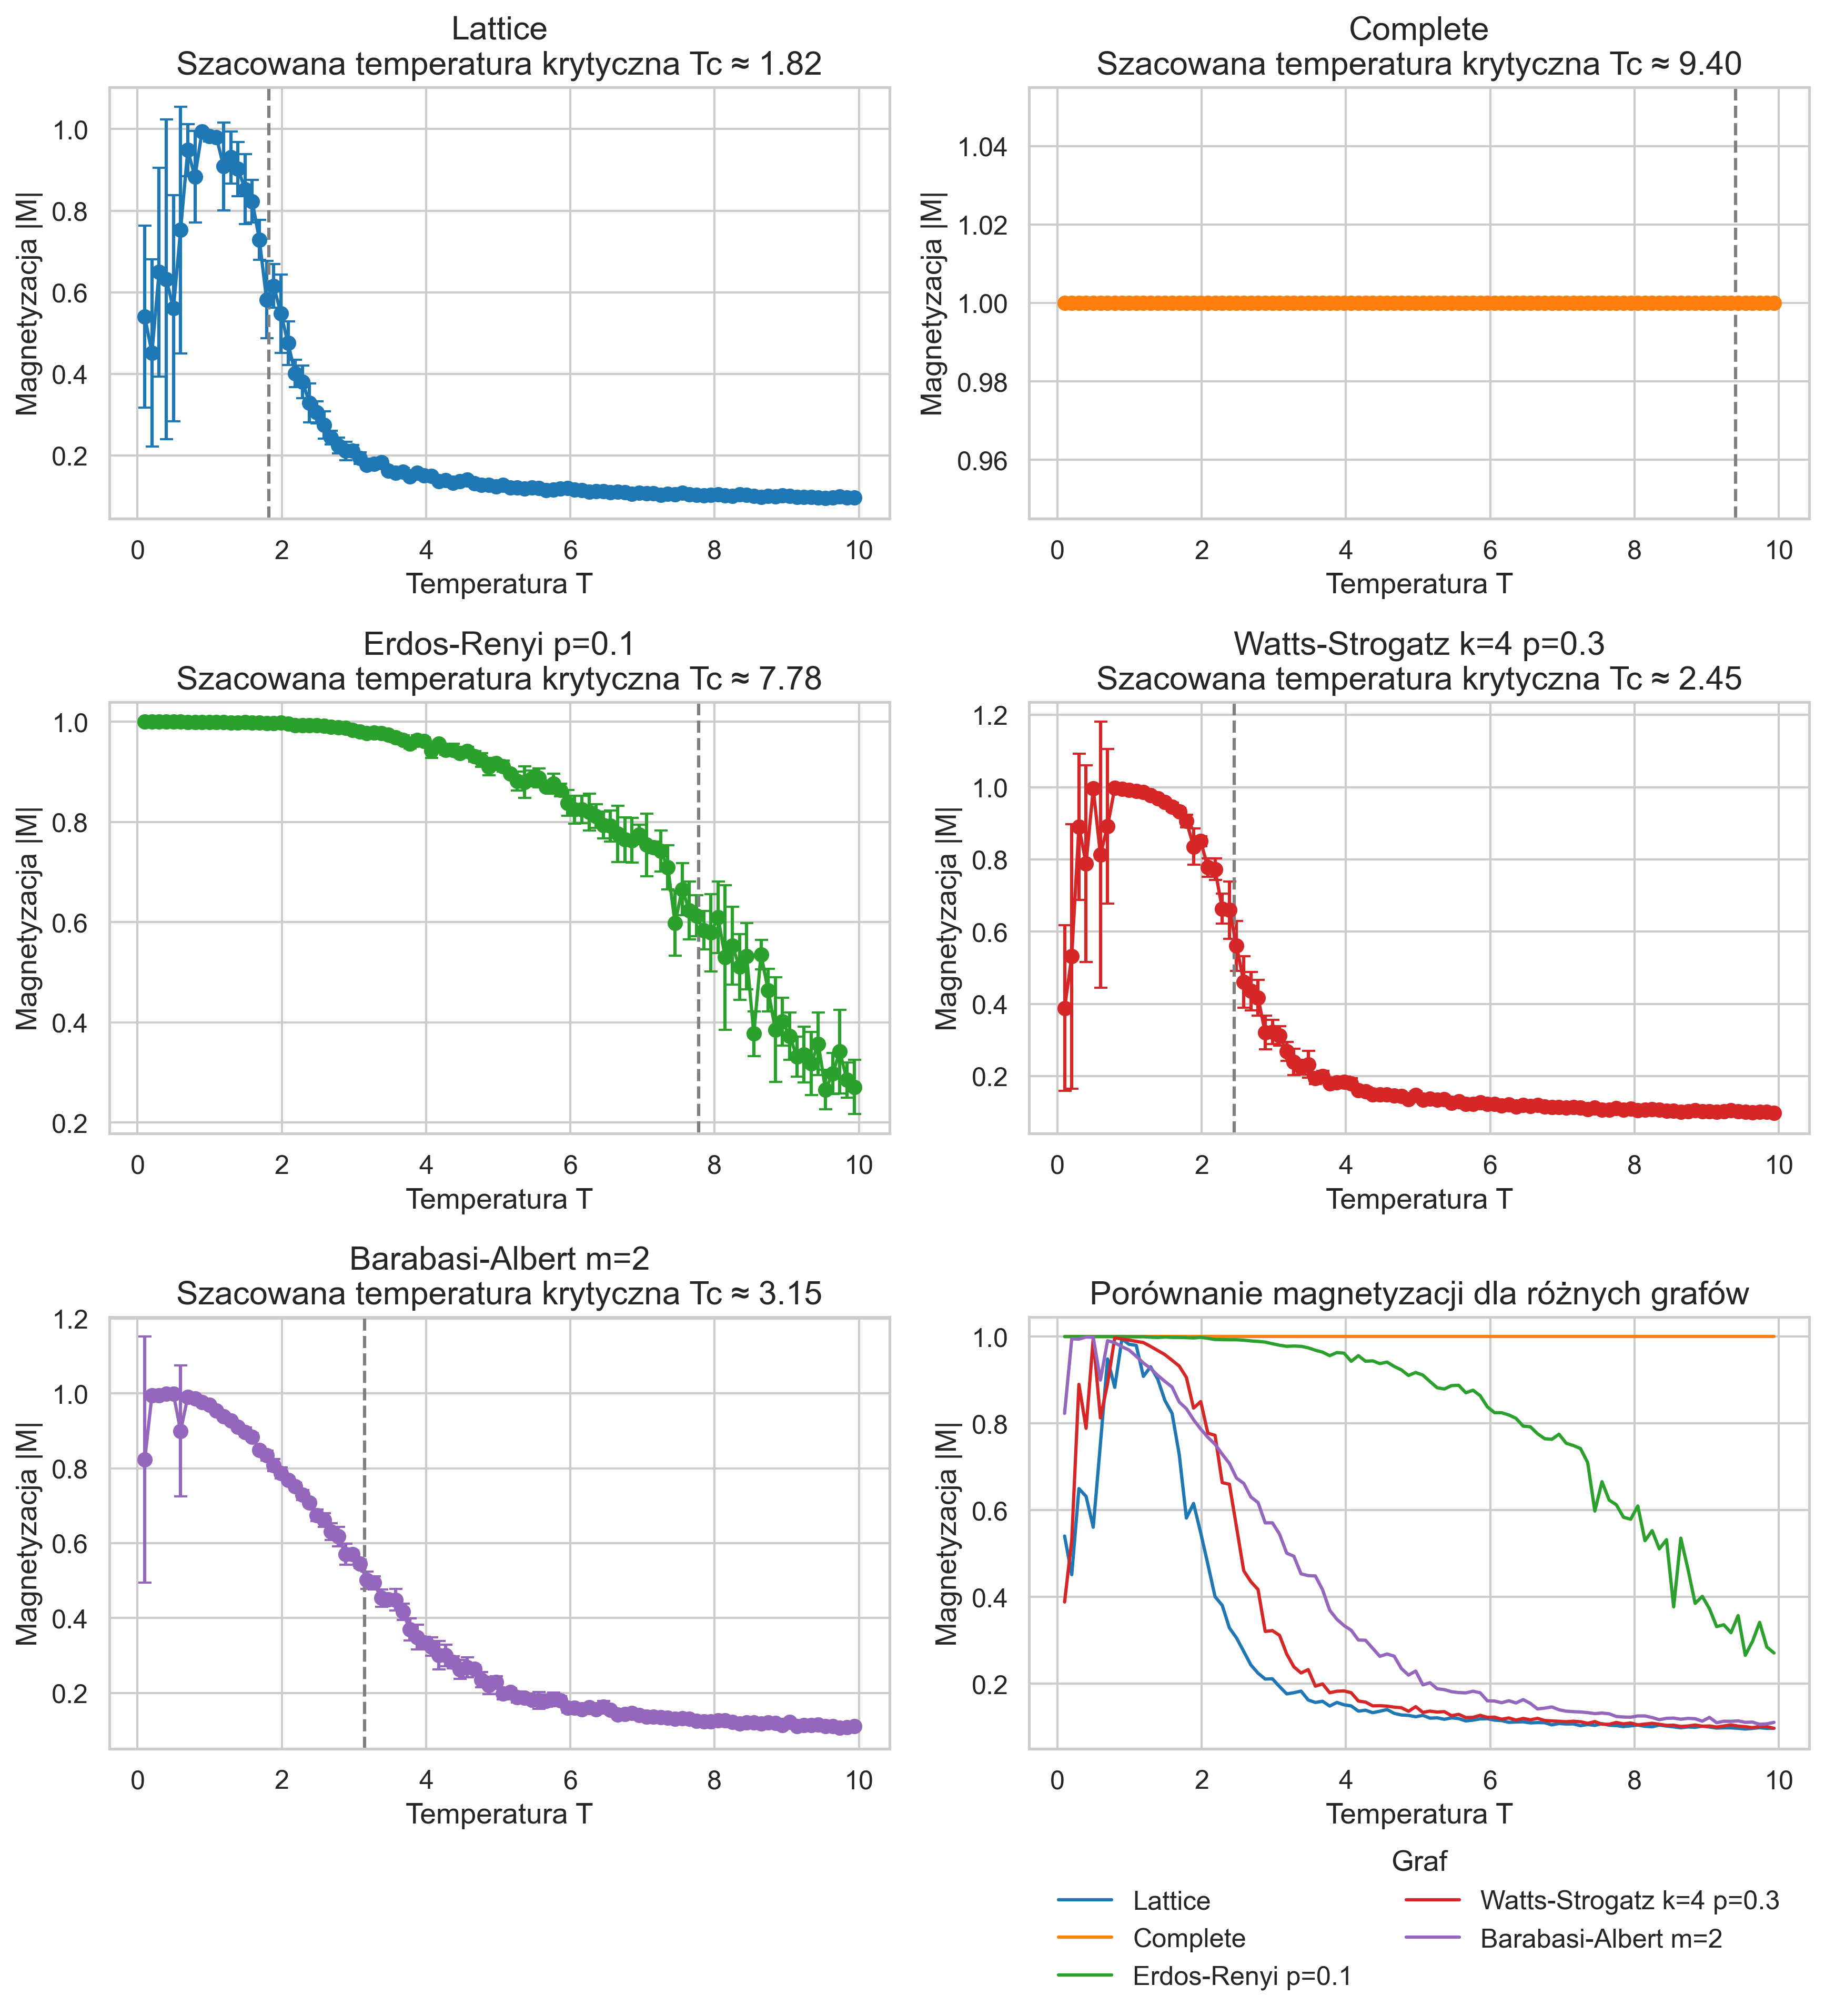

In [ ]:
# 10 x 10
sns.set(style="whitegrid", font_scale=1.1)

names = [
    "Lattice",
    "Complete",
    "Erdos-Renyi p=0.1",
    "Watts-Strogatz k=4 p=0.3",
    "Barabasi-Albert m=2"
]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

fig, axes = plt.subplots(3, 2, figsize=(12, 13), dpi=300)
axes = axes.flatten()

combined_df = pd.DataFrame()

for i, name in enumerate(names):
    df = pd.read_csv(f"results/{name}.csv")
    # co 3 wiersz do wykresu, do większej czytelności
    df_plot = df.iloc[::3, :]
    df_plot["graph"] = name
    combined_df = pd.concat([combined_df, df_plot], ignore_index=True)

    # Tc estimation uywając maksymalnogo gradientu
    T = df["T"].values
    M_smooth = gaussian_filter1d(df["mean_magnetization"], sigma=3)
    dM_dT = np.gradient(M_smooth, T)
    Tc_index = np.argmax(-dM_dT)
    Tc = T[Tc_index]

    ax = axes[i]
    ax.errorbar(df_plot["T"], df_plot["mean_magnetization"], yerr=df_plot["std_magnetization"],
                fmt='o-', capsize=3, color=colors[i % len(colors)])
    ax.axvline(Tc, color='gray', linestyle='--', linewidth=1.5)
    ax.set_title(f"{name}\nSzacowana temperatura krytyczna Tc ≈ {Tc:.2f}", fontsize=15)
    ax.set_xlabel("Temperatura T")
    ax.set_ylabel("Magnetyzacja |M|")
    ax.grid(True)

# Szósty subplot — porównanie
ax = axes[-1]
sns.lineplot(data=combined_df, x="T", y="mean_magnetization", hue="graph", ax=ax, palette=colors)
ax.set_title("Porównanie magnetyzacji dla różnych grafów", fontsize=15)
ax.set_xlabel("Temperatura T")
ax.set_ylabel("Magnetyzacja |M|")
ax.grid(True)

# Przeniesienie legendy pod wykres
ax.legend(title="Graf", bbox_to_anchor=(0.5, -0.18), loc='upper center', ncol=2, frameon=False)

plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.13)
plt.show()


/var/folders/zl/cns9wcts6cd33lrhp33f3rsc0000gn/T/ipykernel_26508/2208222389.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["graph"] = name
/var/folders/zl/cns9wcts6cd33lrhp33f3rsc0000gn/T/ipykernel_26508/2208222389.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["graph"] = name
/var/folders/zl/cns9wcts6cd33lrhp33f3rsc0000gn/T/ipykernel_26508/2208222389.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

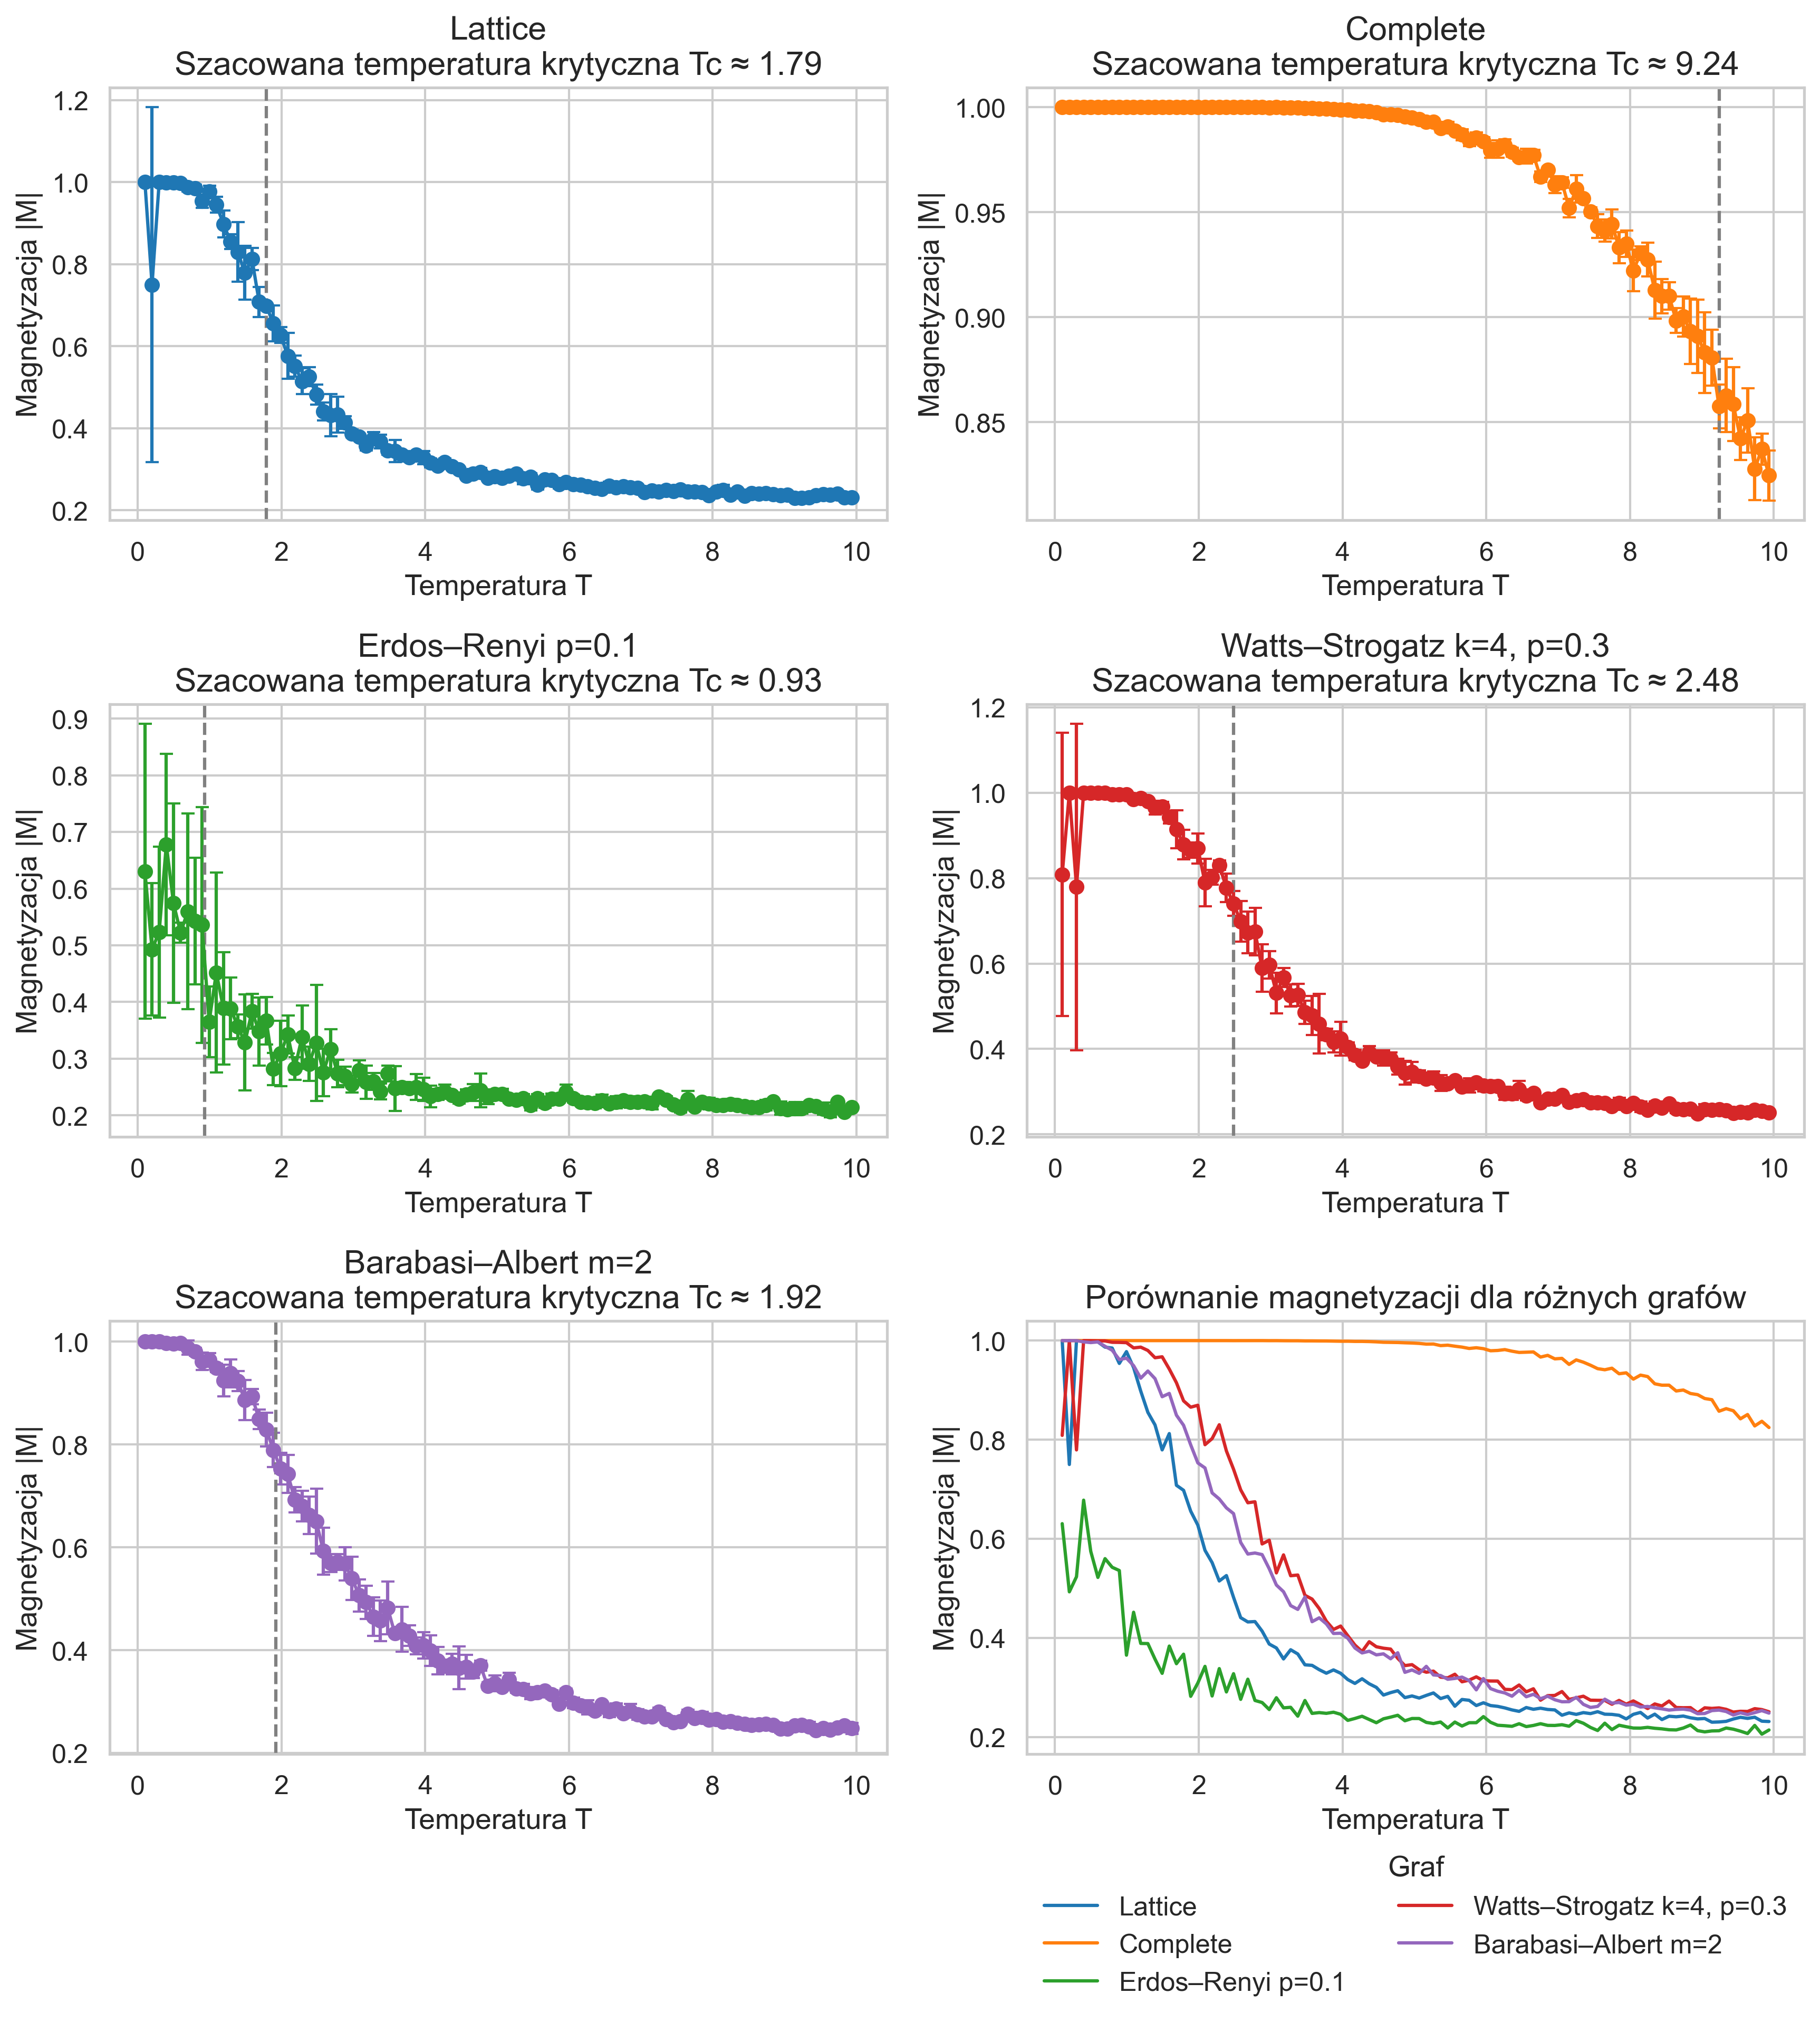

In [64]:
# 4 x 4
sns.set(style="whitegrid", font_scale=1.1)

names = [
    "Lattice",
    "Complete",
    "Erdos–Renyi p=0.1",
    "Watts–Strogatz k=4, p=0.3",
    "Barabasi–Albert m=2"
]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

fig, axes = plt.subplots(3, 2, figsize=(12, 13), dpi=300)
axes = axes.flatten()

combined_df = pd.DataFrame()

for i, name in enumerate(names):
    df = pd.read_csv(f"results_4x4/{name}.csv")
    # co 3 wiersz do wykresu, do większej czytelności
    df_plot = df.iloc[::3, :]
    df_plot["graph"] = name
    combined_df = pd.concat([combined_df, df_plot], ignore_index=True)

    # Tc estimation uywając maksymalnogo gradientu
    T = df["T"].values
    M_smooth = gaussian_filter1d(df["mean_magnetization"], sigma=3)
    dM_dT = np.gradient(M_smooth, T)
    Tc_index = np.argmax(-dM_dT)
    Tc = T[Tc_index]

    ax = axes[i]
    ax.errorbar(df_plot["T"], df_plot["mean_magnetization"], yerr=df_plot["std_magnetization"],
                fmt='o-', capsize=3, color=colors[i % len(colors)])
    ax.axvline(Tc, color='gray', linestyle='--', linewidth=1.5)
    ax.set_title(f"{name}\nSzacowana temperatura krytyczna Tc ≈ {Tc:.2f}", fontsize=15)
    ax.set_xlabel("Temperatura T")
    ax.set_ylabel("Magnetyzacja |M|")
    ax.grid(True)

# Szósty subplot — porównanie
ax = axes[-1]
sns.lineplot(data=combined_df, x="T", y="mean_magnetization", hue="graph", ax=ax, palette=colors)
ax.set_title("Porównanie magnetyzacji dla różnych grafów", fontsize=15)
ax.set_xlabel("Temperatura T")
ax.set_ylabel("Magnetyzacja |M|")
ax.grid(True)

# Przeniesienie legendy pod wykres
ax.legend(title="Graf", bbox_to_anchor=(0.5, -0.18), loc='upper center', ncol=2, frameon=False)

plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.13)
plt.show()

/var/folders/zl/cns9wcts6cd33lrhp33f3rsc0000gn/T/ipykernel_26508/3875110131.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["graph"] = name
/var/folders/zl/cns9wcts6cd33lrhp33f3rsc0000gn/T/ipykernel_26508/3875110131.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["graph"] = name
/var/folders/zl/cns9wcts6cd33lrhp33f3rsc0000gn/T/ipykernel_26508/3875110131.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

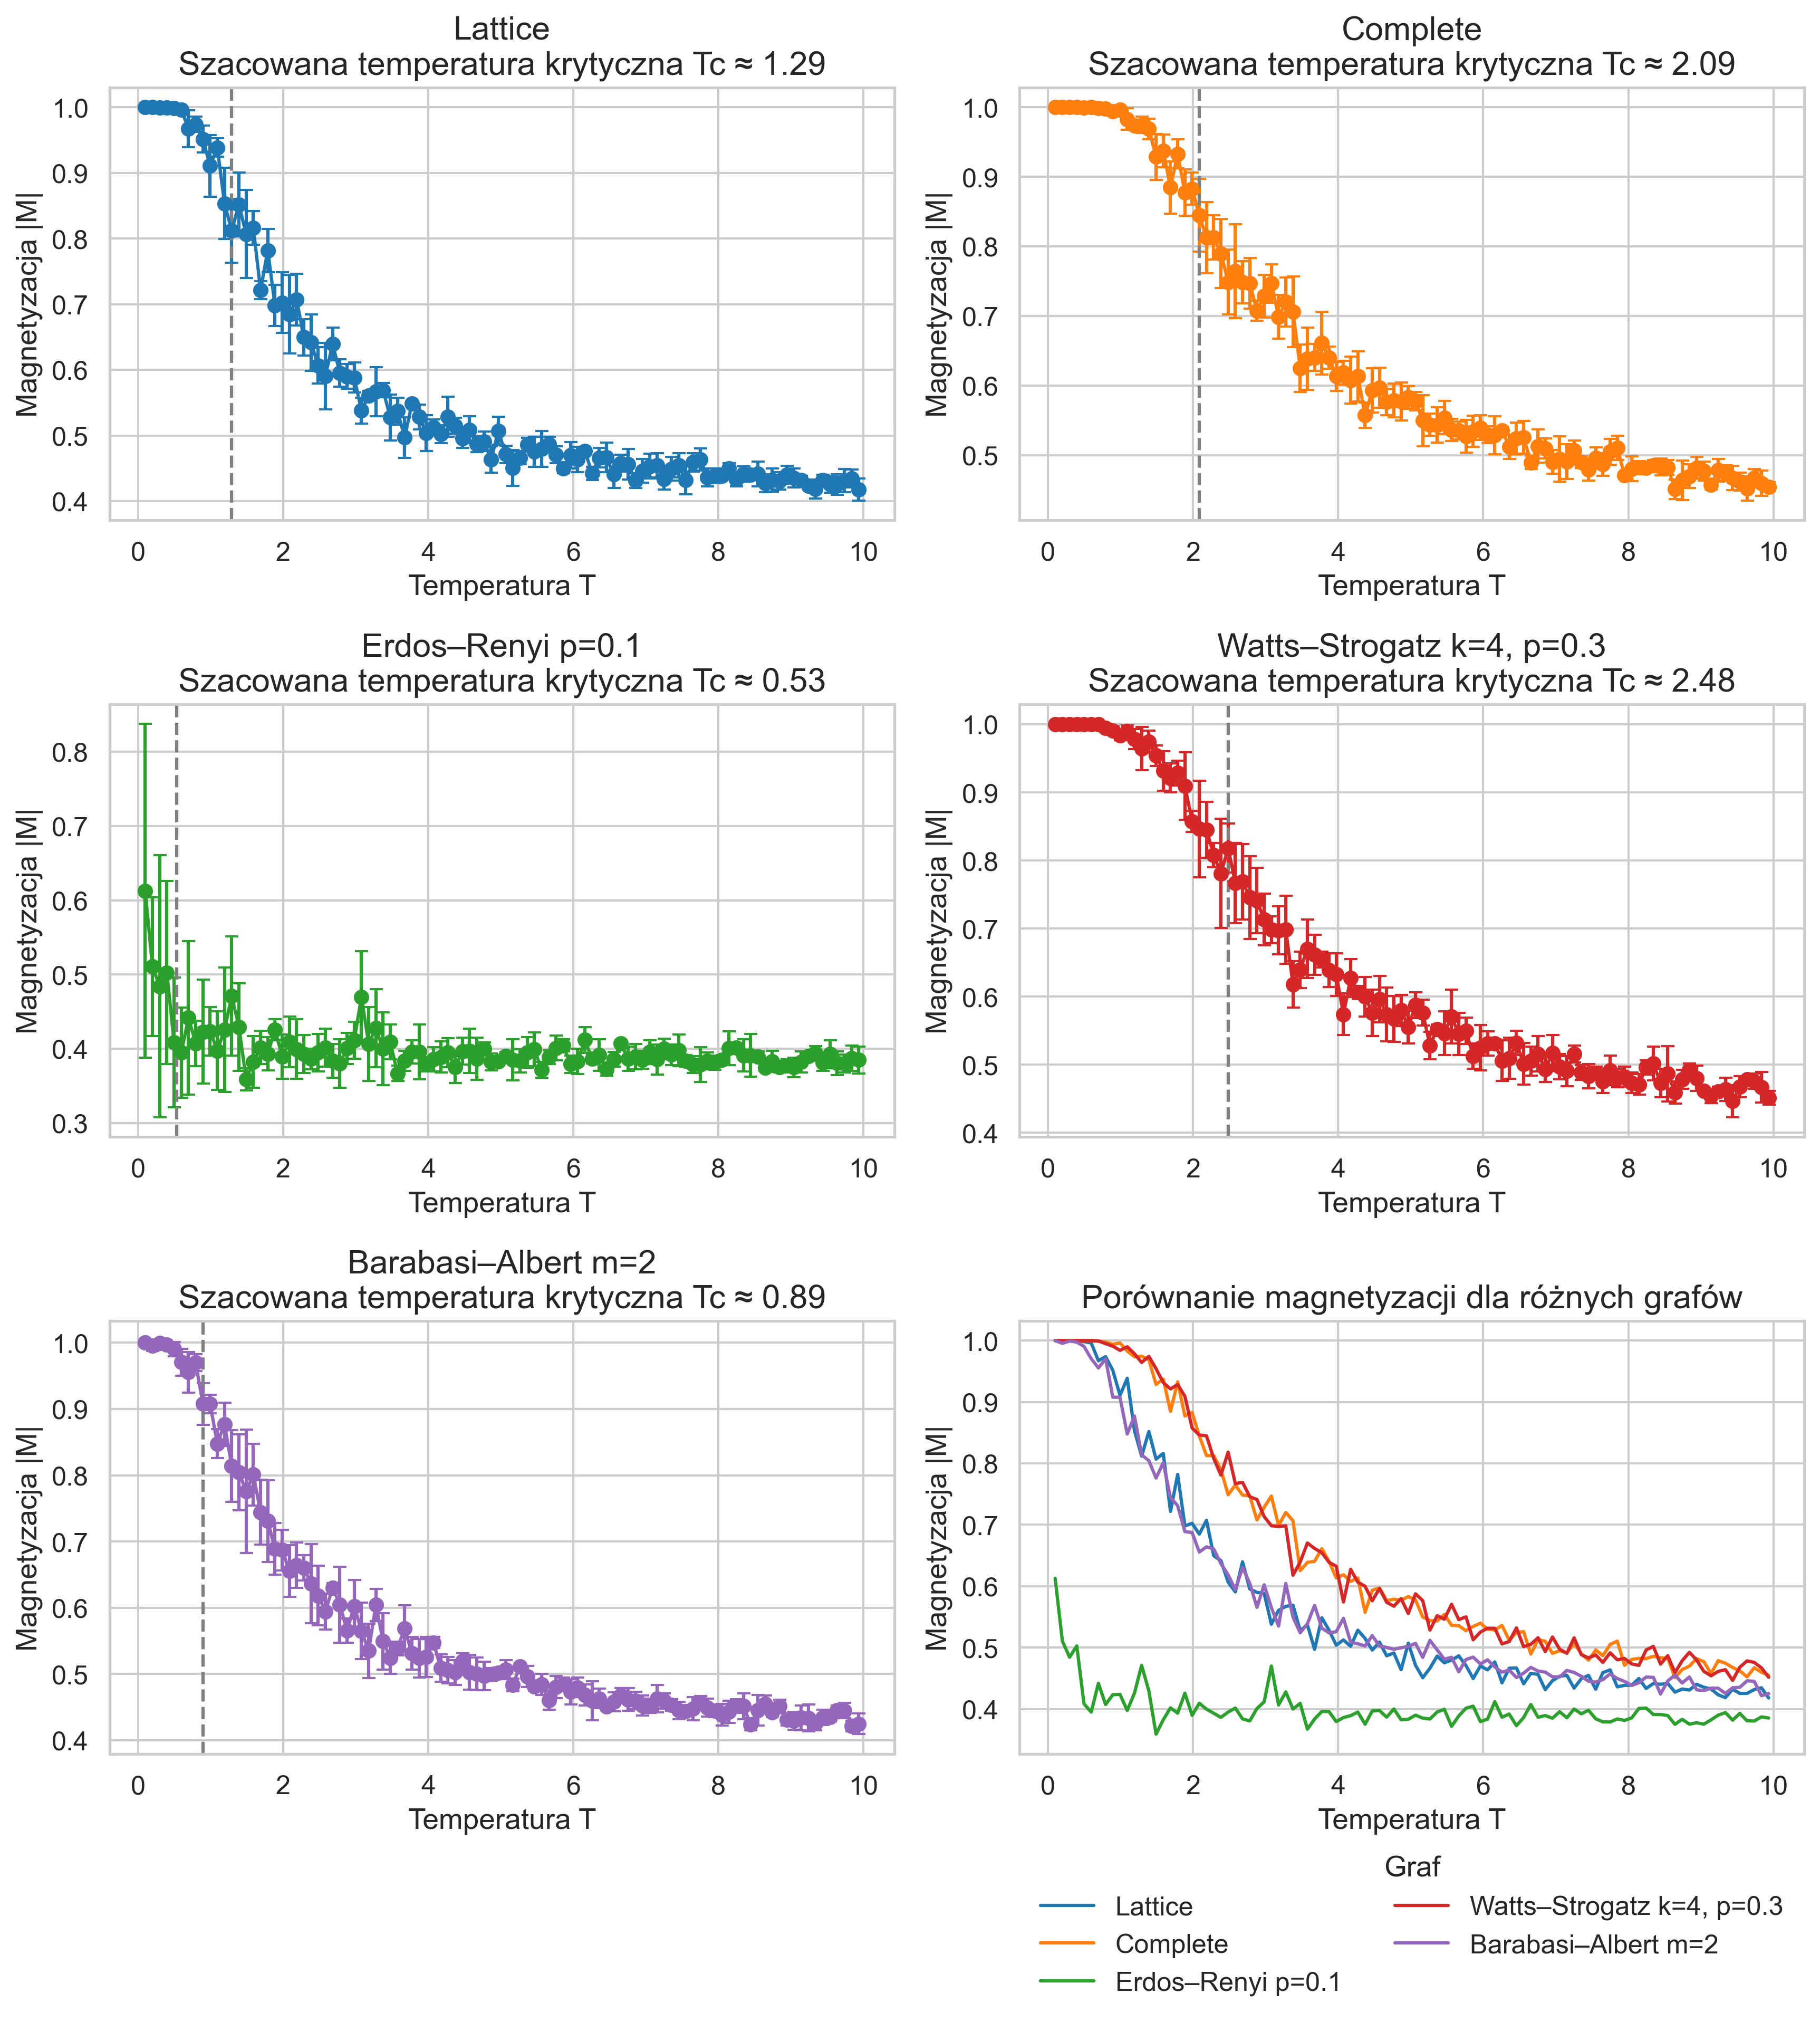

In [66]:
# 2 x 2
sns.set(style="whitegrid", font_scale=1.1)

names = [
    "Lattice",
    "Complete",
    "Erdos–Renyi p=0.1",
    "Watts–Strogatz k=4, p=0.3",
    "Barabasi–Albert m=2"
]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

fig, axes = plt.subplots(3, 2, figsize=(12, 13), dpi=300)
axes = axes.flatten()

combined_df = pd.DataFrame()

for i, name in enumerate(names):
    df = pd.read_csv(f"results_2x2/{name}.csv")
    # co 3 wiersz do wykresu, do większej czytelności
    df_plot = df.iloc[::3, :]
    df_plot["graph"] = name
    combined_df = pd.concat([combined_df, df_plot], ignore_index=True)

    # Tc estimation uywając maksymalnogo gradientu
    T = df["T"].values
    M_smooth = gaussian_filter1d(df["mean_magnetization"], sigma=3)
    dM_dT = np.gradient(M_smooth, T)
    Tc_index = np.argmax(-dM_dT)
    Tc = T[Tc_index]

    ax = axes[i]
    ax.errorbar(df_plot["T"], df_plot["mean_magnetization"], yerr=df_plot["std_magnetization"],
                fmt='o-', capsize=3, color=colors[i % len(colors)])
    ax.axvline(Tc, color='gray', linestyle='--', linewidth=1.5)
    ax.set_title(f"{name}\nSzacowana temperatura krytyczna Tc ≈ {Tc:.2f}", fontsize=15)
    ax.set_xlabel("Temperatura T")
    ax.set_ylabel("Magnetyzacja |M|")
    ax.grid(True)

# Szósty subplot — porównanie
ax = axes[-1]
sns.lineplot(data=combined_df, x="T", y="mean_magnetization", hue="graph", ax=ax, palette=colors)
ax.set_title("Porównanie magnetyzacji dla różnych grafów", fontsize=15)
ax.set_xlabel("Temperatura T")
ax.set_ylabel("Magnetyzacja |M|")
ax.grid(True)

# Przeniesienie legendy pod wykres
ax.legend(title="Graf", bbox_to_anchor=(0.5, -0.18), loc='upper center', ncol=2, frameon=False)

plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.13)
plt.show()

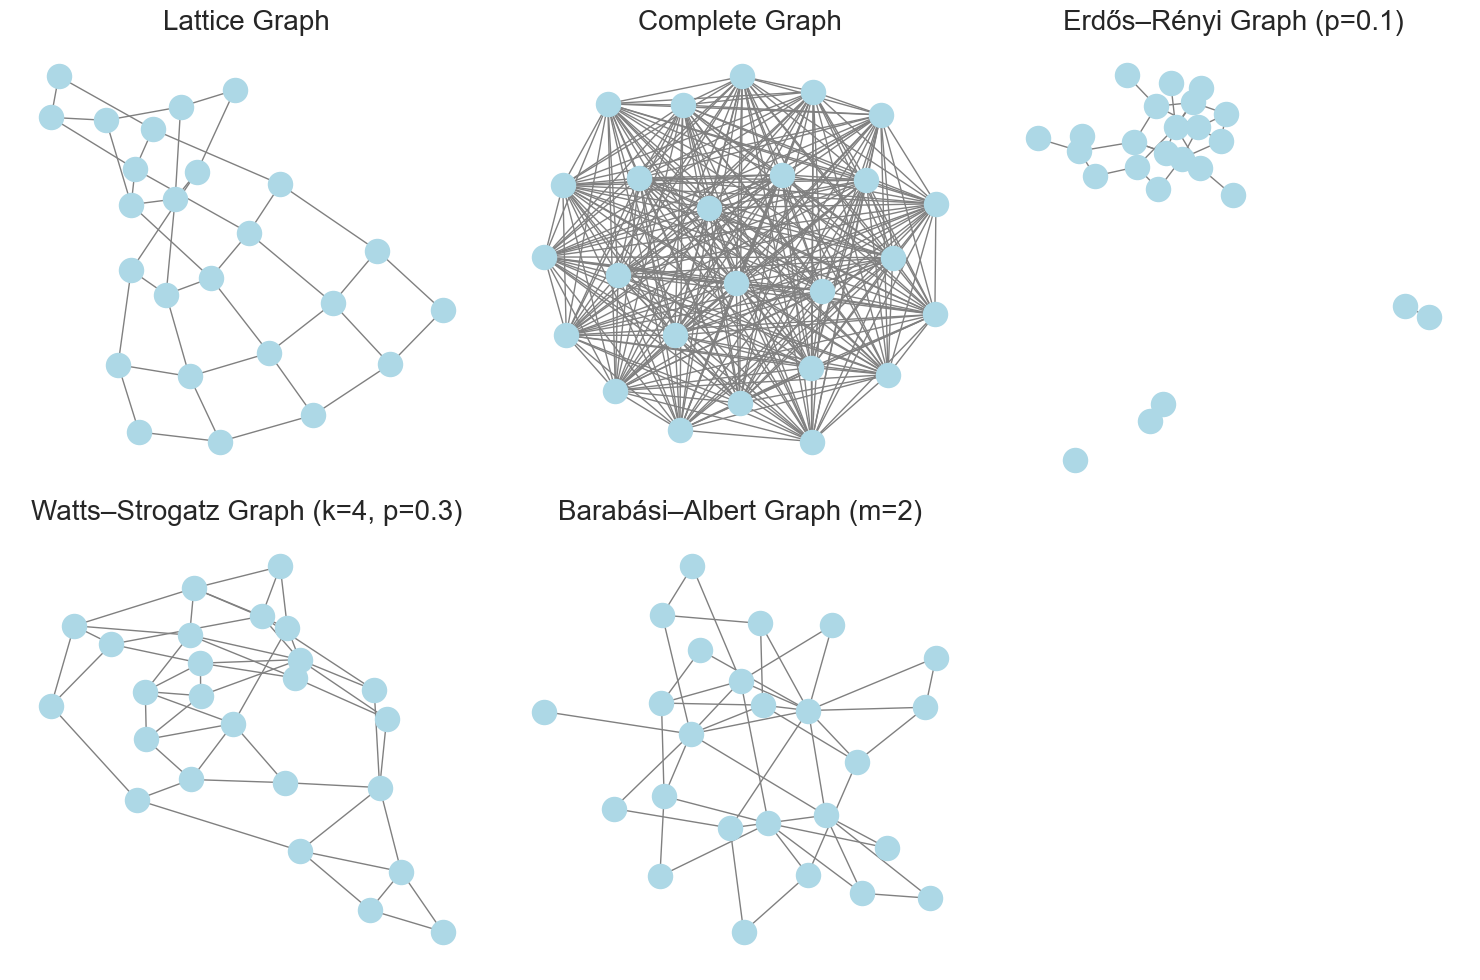

In [60]:
def visualize_graphs_subplot(graphs, layout='spring', L=5):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, (adjacency_matrix, title) in enumerate(graphs):
        G = nx.from_numpy_array(adjacency_matrix)

        if layout == 'spring':
            pos = nx.spring_layout(G, seed=42)
        elif layout == 'kamada':
            pos = nx.kamada_kawai_layout(G)
        elif layout == 'circular':
            pos = nx.circular_layout(G)
        else:
            pos = nx.shell_layout(G)

        ax = axes[i]
        nx.draw(G, pos, ax=ax, with_labels=False, node_color='lightblue',
                edge_color='gray', node_size=300)
        ax.set_title(title, fontsize=20)
        ax.axis('off')

    for j in range(len(graphs), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

L = 5
N = L * L

graphs = [
    (LatticeGraph(L).get_ajacency_matrix(), "Lattice Graph"),
    (CompleteGraph(N).get_ajacency_matrix(), "Complete Graph"),
    (ErdosRenyiGraph(N, p=0.1).get_ajacency_matrix(), "Erdős–Rényi Graph (p=0.1)"),
    (WattsStrogatzGraph(N, k=4, p=0.3).get_ajacency_matrix(), "Watts–Strogatz Graph (k=4, p=0.3)"),
    (BarabasiAlbertGraph(N, m=2).get_ajacency_matrix(), "Barabási–Albert Graph (m=2)")
]
visualize_graphs_subplot(graphs)